In [36]:
import pickle
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt

# read in all the data
trial_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/hsa_identification/2024-05-16_1715893054'
with open(os.path.join(trial_folder, 'experiment_config.yaml'), 'r') as f:
    experiment_config = yaml.load(f, yaml.Loader)
with open(os.path.join(trial_folder, 'hardware_config.yaml'), 'r') as f:
    hardware_config = yaml.load(f, yaml.Loader)
with open(os.path.join(trial_folder, 'data.pickle'), 'rb') as f:
    data = pickle.load(f)

In [37]:
from scipy.sparse import bsr_array
from scipy.optimize import lsq_linear
def calculate_dynamics(x,t):
    M = len(t)
    # A_rows = np.hstack([np.array([3*i, 3*i, 3*i+1, 3*i+1, 3*i+2, 3*i+2]) for i in range(0,M-2)])
    # A_cols = np.hstack([np.array([2*i, 2*i+1, 2*i, 2*i+1, 2*i, 2*i+1]) for i in range(0,M-2)])
    A_rows = np.hstack([np.array([2*i, 2*i, 2*i+1, 2*i+1]) for i in range(0,M-2)])
    A_cols = np.hstack([np.array([2*i, 2*i+1, 2*i, 2*i+1]) for i in range(0,M-2)]) 
    A_data = []
    # b = np.zeros(3*(M-2))
    b = np.zeros(2*(M-2))
    for i in range(M-2):
        dt = t[i]-t[i-1]
        # what was the equation? I think there is a mistake here...
        #x[i] = x[i+1]-dt*xdot[i+1]+.5*xdot[i+1]**2
        #x[i+2] = x[i+1]+dt*xdot[i+1]+.5*xdot[i+1]**2
        # A_data.append([-dt, .5*dt**2, 1, dt, -1, dt, .5*dt**2])
        A_data.append([-dt, .5*dt**2, dt, .5*dt**2])
        # b[3*i] = x[i]-x[i+1]
        b[2*i] = x[i]-x[i+1]
        # b[3*i+1] = 0.
        # b[3*i+2] = x[i+2]-x[i+1]
        b[2*i+1] = x[i+2]-x[i+1]
    data = np.hstack(A_data)
    A_sparse = bsr_array((data,(A_rows,A_cols)), shape=(2*(M-2),2*(M-2)))
    result = lsq_linear(A_sparse, b)
    xdot = result.x[0:-1:2]
    xddot = result.x[1::2] 
    return xdot, xddot

In [38]:
# downsample the data and fit the dynamics
skip = 20
x = [np.array(arr[0::skip]) for arr in data['motor_angle']]
tau = [np.array(arr[0::skip]) for arr in data['motor_torque']]
l = [np.array(arr[0::skip]) for arr in data['hsa_len']]
dldx = [np.array(arr[0::skip]) for arr in data['dldtheta']]
t = [np.array(arr[0::skip]) for arr in data['times']]
psi = data['hsa_angle']
xdot = []
xddot = []
for i in range(len(x)):
    _xdot, _xddot = calculate_dynamics(x[i],t[i])
    xdot.append(_xdot)
    xddot.append(_xddot)

In [39]:
print(psi)

[45.0, 90.0, 135.0]


In [40]:
# pick 5 lengths uniformly from each trial
Nl = 12
l_min = min([min(l[i]) for i in range(len(psi))])
l_max = max([max(l[i]) for i in range(len(psi))])

y = np.vstack(tuple([[_l, psi[i]] for _l in np.linspace(l_min,l_max, Nl)] for i in range(len(psi)))).T
print(y.shape)


(2, 36)


In [41]:
"""
Experimental - fitting two potential functions and blending them together with a logistic function
"""

from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from hsa_hopper.hsa_model import HSAPotential

# logistic function for blending HSA potentials
logi = lambda ldot, a: 1/(1+np.exp(-a*ldot))
s = 3 # length scale for the Gaussian process regressor
a = 10 # width of logistic function
v = np.zeros((2,y.shape[1]))
model = HSAPotential(v, y, a, s)

# stack all the data for access by a common index
_x = np.hstack([x[i][1:-1] for i in range(len(x))])
_t = np.hstack([t[i][1:-1] for i in range(len(x))])
_xdot = np.hstack(xdot)
_xddot = np.hstack(xddot)
_l = np.hstack([l[i][1:-1] for i in range(len(x))])
_dldx = np.hstack([dldx[i][1:-1] for i in range(len(x))])
_tau = np.hstack([tau[i][1:-1] for i in range(len(x))])
_psi = np.hstack([len(x[i])*[psi[i]] for i in range(len(x))])
# thats a pretty damn big system of equations
# lets assemble the A-matrix and b-vector
N = y.shape[1]
M = len(_x)
A = np.zeros((M,2*(N+1)))
b = np.zeros((M))
for i in range(M):
    b[i] = _tau[i]
    A[i,0] = _xddot[i]
    A[i,1] = _xdot[i]
    ldot = _dldx[i]*_xdot[i]
    z = np.vstack((_l[i],_psi[i]))
    dk = model.dk(z)
    A[i,2:-1:2] = _dldx[i]*logi(ldot,model.a)*dk[0,:]
    A[i,3::2] = _dldx[i]*(1-logi(ldot,model.a))*dk[0,:]
        
ATA = A.T@A
ATb = A.T@_tau
bTb = _tau.T@_tau
f = lambda x: x.T@ATA@x+bTb-2*x.T@ATb
jac = lambda x: 2*ATA@x-2*ATb
hess = lambda x: 2*ATA

# next constraints - enforce positive weights
# and positive definiteness of stiffness at collocation points
C = np.zeros((2,2+2*N))
# C = np.zeros((2+N,2+N))
C[0,0] = 1
C[1,1] = 1
lb = np.array([1e-3,3e-2])
ub = np.array([5e-3,1e-1])
# lb = np.zeros(2+N)
# for j in range(N):
    # z = y[j,:]
    # K = [(potential.drho(z,k)@potential.drho(z,k).T-potential.d2rho(z,k))[0,0] for k in range(N)] 
    # C[2+j,2:] = K

constraints = [LinearConstraint(C,lb=lb,ub=ub)]

x0 = np.zeros(2+2*N)
result = minimize(f, x0, 
                  jac=jac, 
                  hess=hess, 
                  constraints=constraints, 
                  method='trust-constr',
                  options={'maxiter' : 2000})

In [42]:
# model.v = result.x[2:]
model.v[0,:] = result.x[2:-1:2]
model.v[1,:] = result.x[3::2]
with open(os.path.join('hsa_model.yaml'), 'w') as f:
    yaml.dump(model.attribute_dict(), f, yaml.Dumper)
print(result)
print(f'R2 = {1-result.fun/np.sum((b-np.average(b))**2)}')

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 29.298128978083696
                 x: [ 5.000e-03  9.983e-02 ...  4.642e+02  3.261e+02]
               nit: 160
              nfev: 209
              njev: 78
              nhev: 78
          cg_niter: 2004
      cg_stop_cond: 2
              grad: [-2.282e+03 -9.566e-01 ... -8.411e-04 -2.038e-03]
   lagrangian_grad: [-4.457e-11 -2.676e-08 ... -8.411e-04 -2.038e-03]
            constr: [array([ 5.000e-03,  9.983e-02])]
               jac: [array([[ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  1.000e+00, ...,  0.000e+00,
                             0.000e+00]])]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([ 2.282e+03,  9.566e-01])]
            method: tr_interior_point
        optimality: 0.003072976140245487
  constr_violation

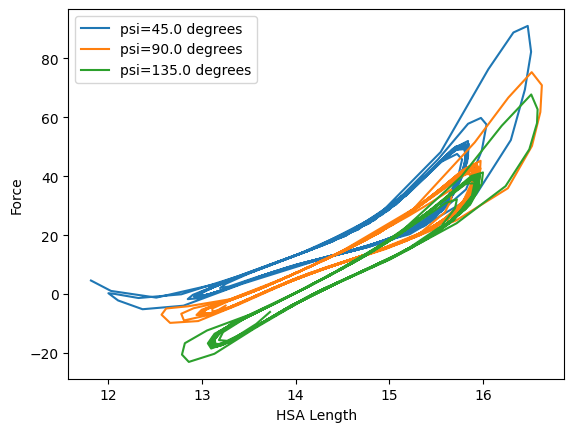

In [45]:
# pick a trajectory to plot this shitshow

for idx in range(len(psi)):
# for idx in [0,1,2,3]:
    _psi = psi[idx]
    _x = x[idx][1:-1]
    _xdot = xdot[idx]
    _dldx = dldx[idx][1:-1]
    _l = l[idx][1:-1]
    _ldot = _dldx*_xdot
    _z = np.array([[_l[i],_psi] for i in range(_l.shape[0])])
    _F = np.array([model.dV(_l[i],_psi,_ldot[i]) for i in range(_l.shape[0])])
    # plt.plot(180/np.pi*_x,_F,label=f'psi={_psi} degrees')
    plt.plot(100*_l,_F,label=f'psi={_psi} degrees')
plt.xlabel('HSA Length')
plt.ylabel('Force')
plt.legend()

NameError: name 'potential2' is not defined

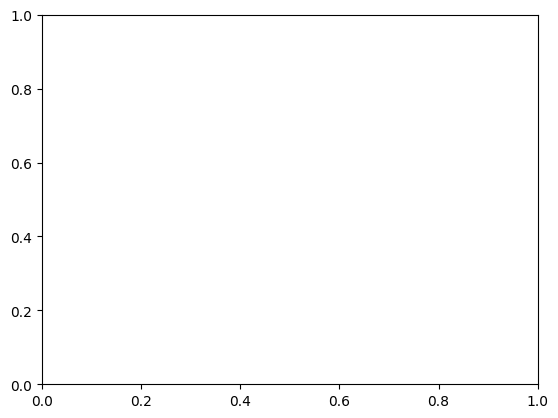

In [44]:
# plot this potential function for a range of theta values, fix psi = 0.

# for i in range(len(psi)):
fig, ax = plt.subplots()
for i in range(0,len(psi)):
    _psi = psi[i]
    hsa_lens = np.linspace(min(l[i]), max(l[i]), 100)
    motor_angles = np.linspace(min(x[i]),max(x[i]),100)
    z = np.array([[l, _psi] for l in hsa_lens])
    ax.plot(z[:,0]*100, [potential2.dV(z[i,:])[0] for i in range(len(hsa_lens))], label=f'psi = {(_psi):.1f} deg')
    # ax.plot(180/np.pi*motor_angles, [potential2.dV(z[i,:])[0] for i in range(len(hsa_lens))], label=f'psi = {(_psi):.1f} deg')
ax.set_title('Linear Force vs HSA Length')
ax.set_xlabel('Length (cm)')
ax.set_ylabel('Force (N)')

xmin = min(min(line.get_xdata()) for line in ax.lines)
xmax = max(max(line.get_xdata()) for line in ax.lines)
ymin = min(min(line.get_ydata()) for line in ax.lines)
ymax = max(max(line.get_ydata()) for line in ax.lines)
ax.fill_between([xmin, 12], [ymin, ymin], [ymax, ymax], color='r', alpha=.15, label='non-linear compression')
ax.fill_between([12,16], [ymin, ymin], [ymax, ymax], color='b', alpha=.15, label='quasi-linear region')
ax.fill_between([16,xmax], [ymin, ymin], [ymax, ymax], color='g', alpha=.15, label='non-linear extension')
ax.grid()
ax.legend()

In [ ]:
fig, ax = plt.subplots()
# for i in range(len(psi)):
for i in range(0,len(psi),2):
    print(i)
    _psi = psi[i]
    hsa_lens = np.linspace(min(l[i]), max(l[i]), 100)
    motor_angles = np.linspace(min(x[i]),max(x[i]),100)
    z = np.array([[l, _psi] for l in hsa_lens])
    ax.plot(100*z[:,0], [potential.V(z[i,:]) for i in range(len(hsa_lens))], label=f'psi = {_psi:.1f} deg')
ax.set_title('Change in Energy vs HSA Length')
ax.set_xlabel('HSA length')
ax.set_ylabel('Joules')
for i, line in enumerate(ax.lines):
    ydata = np.array(line.get_ydata())
    ydata -= np.min(ydata)
    line.set_ydata(ydata)
ymin = min(min(line.get_ydata()) for line in ax.lines)
ymax = max(max(line.get_ydata()) for line in ax.lines)
ax.fill_between([xmin, 12], [ymin, ymin], [ymax, ymax], color='r', alpha=.15, label='non-linear compressoin')
ax.fill_between([12,16], [ymin, ymin], [ymax, ymax], color='b', alpha=.15, label='quasi-linear region')
ax.fill_between([16,xmax], [ymin, ymin], [ymax, ymax], color='g', alpha=.15, label='non-linear extension')
ax.set_ylim([ymin-.1, ymax+.1])
# ax.legend(loc=[.35,.45])
ax.legend()

In [ ]:
# print an energy heatmap
l_vec = np.linspace(.16,.18,20)
psi_vec = np.linspace(-61*np.pi/180,-30*np.pi/180, 20)
X,Y  = np.meshgrid(l_vec,psi_vec)
# Z1 = np.array([[ potential.V(np.array([X[i,j],Y[i,j]])) for j in range(X.shape[1])] for i in range(X.shape[0])])
Z2 = np.array([[ potential.dV(np.array([X[i,j],Y[i,j]]))[0] for j in range(X.shape[1])] for i in range(X.shape[0])])
Z3 = np.array([[ potential.d2V(np.array([X[i,j],Y[i,j]]))[0,0] for j in range(X.shape[1])] for i in range(X.shape[0])])
Z3 = np.clip(Z3, 1, np.inf)

In [ ]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(6,10))
CS11 = ax[0].contour(100*X,180*Y/np.pi,Z2, cmap='Reds')
CS12 = ax[0].contourf(100*X,180*Y/np.pi,Z2, cmap='Reds')
CS21 = ax[1].contour(100*X,180*Y/np.pi,Z3, cmap='Reds',)
CS22 = ax[1].contourf(100*X,180*Y/np.pi,Z3, cmap='Reds',)
ax[0].set_title('Force and Stiffness, Large Extension at Large Torsion')
ax[0].set_ylabel('Twist (deg)')
ax[1].set_ylabel('Twist (deg)')
ax[0].set_xlabel('HSA Length (cm)')
ax[1].set_xlabel('HSA Length (cm)')
fig.colorbar(CS12, label='Force (N)')
fig.colorbar(CS22, label='Stiffness (N/m)')

In [ ]:
from scipy.optimize import root_scalar
# code to find rest length of HSA as a function of twist

def R(psi, bracket):
    f = lambda l, psi: potential.dV(np.array([l, psi]))[0]
    sol = root_scalar(f, (psi,), method='bisect', bracket=bracket, xtol = 1e-9)
    return sol.root

In [ ]:
from scipy.optimize import minimize, LinearConstraint
omega = (5*np.pi)
mass = np.array([1.2, 1.8, 2.2])
E = np.array([m*9.81*.04 for m in mass])
K_sys = np.array([m*omega**2 for m in mass])
K_ground = np.array([10000, 5000, 2000, 1000])
K_leg = np.array([[1/(1/K1-1/K2) for K2 in K_ground] for K1 in K_sys])
dx = np.array([
    [np.sqrt(2*E[i]/K_leg[i,j]/(1+K_leg[i,j]/K_ground[j])) for j in range(len(K_ground))] 
    for i in range(len(E))
])
E_leg = np.array([
    [.5*K_leg[i,j]*dx[i,j]**2 for j in range(dx.shape[1])]
    for i in range(dx.shape[0])
])

# lots and lots of analysis
def F(z, dx, E_leg):
    # get rest length
    l0 = z[0]
    l1 = l0 + dx
    z0 = np.array([l0, z[1]])
    z1 = np.array([l1, z[1]])
    E = potential.V(z1)-potential.V(z0)
    f = (E - E_leg)**2

    # calculate gradient wrt psi
    dE = potential.dV(z1)-potential.dV(z0)
    return f, 2*(E-E_leg)*dE

result = np.zeros((2,*dx.shape))
for i in range(dx.shape[0]):
    for j in range(dx.shape[1]):
        z0 = [R(0., [.11,.18]),10*np.pi/180]
        constraints = [
            LinearConstraint(np.array([1,0]),lb=.1,ub=.1825-dx[i,j]),
            LinearConstraint(np.array([0,1]),lb=-60*np.pi/180,ub=np.pi/4)
        ]
        sol = minimize(F,z0,args=(dx[i,j],E_leg[i,j]),method='SLSQP',jac=True,constraints=constraints)
        result[:,i,j] = sol.x
        print(sol)


In [ ]:
# print(sol.x*180/np.pi)
# print(R(sol.x, [.1,.18])+dx[1,2])
print(result[0,:,:])
print(result[0,:,:]+dx)
print(result[1,:,:]*180/np.pi)